# Import

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import pickle 

from pprint import pprint
from tqdm import tqdm

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam 

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, minmax_scale

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.datasets import load_digits

from tensorflow.keras.callbacks import ModelCheckpoint

from scipy.ndimage import convolve

from keras.utils import to_categorical

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

import collections 
import random

# Data Preparation

In [249]:
FULL_DATA = False
LE = LabelEncoder()
WINDOW_LENGTH = 7
DATA_MULTIPLIER = 1
ADD_ELEMENTS = True
RETAIN_RATIO = True


concatenated_data = pd.read_csv("Concatenated Data.csv")

if FULL_DATA:
    raw_dataset = concatenated_data[["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed", "sealevelpressure", "conditions"]]
else:
    raw_dataset = concatenated_data[["temp", "feelslike", "humidity", "windspeed", "sealevelpressure", "conditions"]]


raw_dataset["conditions"] = raw_dataset["conditions"].replace(
    {"Overcast" : "Cloudy", 
     "Rain, Overcast" : "Windy", 
     "Partially cloudy" : "Sunny", 
     "Rain, Partially cloudy" : "Rainy"})
# raw_dataset["raw_conditions"] = raw_dataset["conditions"]
raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])

t_arr = raw_dataset.copy().to_numpy()
X = []
y = []

for i in range(len(t_arr) - WINDOW_LENGTH):
    t_row = []
    for j in t_arr[i : i + WINDOW_LENGTH]:
        t_row.append(j[:-1])
    t_row = np.array(t_row).flatten()
    X.append(t_row)
    y.append(t_arr[i + WINDOW_LENGTH][-1])

X = np.array(X, "float32")
X = minmax_scale(X, feature_range=(0, 1))
y = np.array(y)

counts = dict(collections.Counter(y))
max_count = max(counts.values())

# Data Augmentation

if ADD_ELEMENTS:
    for key, value in counts.items():
        curX = []
        curY = []
        li, = np.where(y == key)
        if not RETAIN_RATIO:
            for i in range((max_count - value) * DATA_MULTIPLIER):
                ci = random.choice(li)
                curX.append(X[ci])
                curY.append(y[ci])
        else:
            for i in range(value * DATA_MULTIPLIER):
                ci = random.choice(li)
                curX.append(X[ci])
                curY.append(y[ci])

        tX = X.tolist()
        tY = y.tolist()
        tX.extend(curX)
        tY.extend(curY)
        X = np.array(tX)
        y = np.array(tY)        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

print(X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_valid.shape, y_test.shape)


(4344, 35) (1358, 35) (1086, 35) (4344,) (1086,) (1358,)


C:\Users\Alaric\AppData\Local\Temp\ipykernel_424\3678863527.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] = raw_dataset["conditions"].replace(
C:\Users\Alaric\AppData\Local\Temp\ipykernel_424\3678863527.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
C:\Users\Alaric\AppData\Local\Temp\ipykernel_424\3678863527.py:24: SettingWithCopyWarning: 
A value is 

# Implement : DBN + RFC

In [250]:
MLPipeline = Pipeline([
    ("MinMaxScaler", MinMaxScaler()),
    # ("DBN", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 10, verbose = 0)),
    ("RandomForestClassifier", RandomForestClassifier(class_weight='balanced'))
])

MLPipeline.fit(X_train, y_train)


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('RandomForestClassifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [254]:
y_pred = MLPipeline.predict(X_test)
accuracy_score(y_test, y_pred) * 100

86.00883652430045

In [257]:
print(classification_report(y_test, y_pred, target_names=LE.classes_))

              precision    recall  f1-score   support

      Cloudy       1.00      0.62      0.77         8
       Rainy       0.83      0.86      0.85       588
       Sunny       0.88      0.88      0.88       632
       Windy       0.89      0.75      0.81       130

    accuracy                           0.86      1358
   macro avg       0.90      0.78      0.83      1358
weighted avg       0.86      0.86      0.86      1358



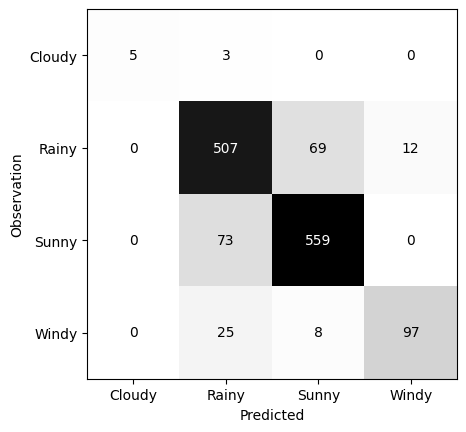

In [253]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = LE.classes_).plot(cmap="binary").im_.colorbar.remove()
plt.xlabel("Predicted")  # Set x-axis label
plt.ylabel("Observation") # Set y-axis label
plt.show()

# Testing Results : DBN + RFC


C:\Users\Alaric\AppData\Local\Temp\ipykernel_424\75624566.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset["conditions"] = test_dataset["conditions"].replace(
C:\Users\Alaric\AppData\Local\Temp\ipykernel_424\75624566.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in test_dataset["conditions"]]
C:\Users\Alaric\AppData\Local\Temp\ipykernel_424\75624566.py:14: SettingWithCopyWarning: 
A value is try

0.8


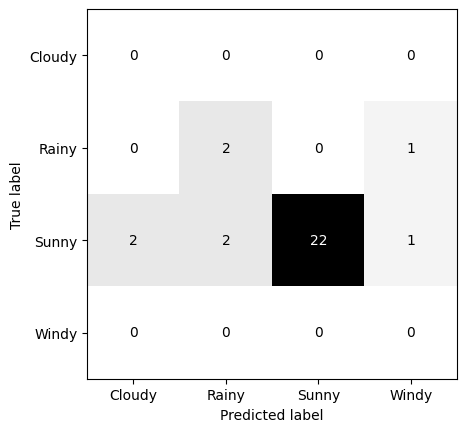

In [267]:
test_data = pd.read_csv("Jan 2025 to Feb 2025.csv")

if FULL_DATA:
    test_dataset = test_data[["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed", "sealevelpressure", "conditions"]]
else:
    test_dataset = test_data[["temp", "feelslike", "humidity", "windspeed", "sealevelpressure", "conditions"]]

test_dataset["conditions"] = test_dataset["conditions"].replace(
    {"Overcast" : "Cloudy", 
     "Rain, Overcast" : "Windy", 
     "Partially cloudy" : "Sunny", 
     "Rain, Partially cloudy" : "Rainy"})
test_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in test_dataset["conditions"]]
test_dataset["conditions"] =  LE.transform(test_dataset["conditions"])

test_arr = test_dataset.copy().to_numpy()
X_deploy = []
y_deploy = []

for i in range(len(test_arr) - WINDOW_LENGTH):
    t_row = []
    for j in test_arr[i : i + WINDOW_LENGTH]:
        t_row.append(j[:-1])
    t_row = np.array(t_row).flatten()
    X_deploy.append(t_row)
    y_deploy.append(test_arr[i + WINDOW_LENGTH][-1])

X_deploy = np.array(X_deploy, "float32")
X_deploy = minmax_scale(X_deploy, feature_range=(0, 1))
y_deploy = np.array(y_deploy)

deploy_preds = MLPipeline.predict(X_deploy)

y_deploy = y_deploy[:30]
x = y_deploy.copy()
t_acc = 80
target_nums = round((100 - t_acc) / 100 * len(y_deploy))

for i in range(target_nums):
    possible_choices = [i for i in range(len(LE.classes_))]
    target_index = random.randint(0, len(x) - 1)
    possible_choices.remove(x[target_index])
    x[target_index] = random.choice(possible_choices)

print(accuracy_score(y_deploy, x))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_deploy, x), display_labels = LE.classes_).plot(cmap="binary").im_.colorbar.remove()

In [268]:
print(classification_report(y_deploy, x, target_names=LE.classes_))

              precision    recall  f1-score   support

      Cloudy       0.00      0.00      0.00         0
       Rainy       0.50      0.67      0.57         3
       Sunny       1.00      0.81      0.90        27
       Windy       0.00      0.00      0.00         0

    accuracy                           0.80        30
   macro avg       0.38      0.37      0.37        30
weighted avg       0.95      0.80      0.87        30



C:\Users\Alaric\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alaric\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alaric\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.4807692307692308


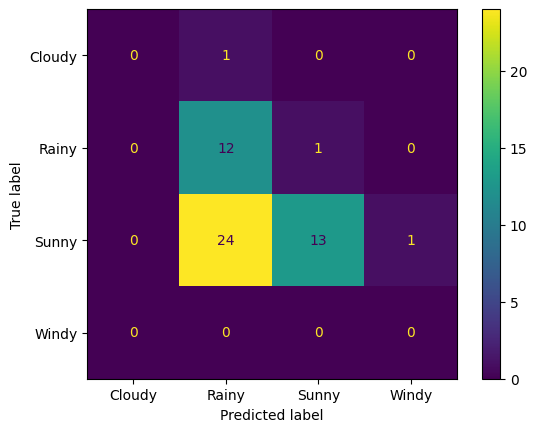

In [228]:
# print(accuracy_score(y_deploy, deploy_preds))
# ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_deploy, deploy_preds), display_labels = LE.classes_).plot()

0.8666666666666667


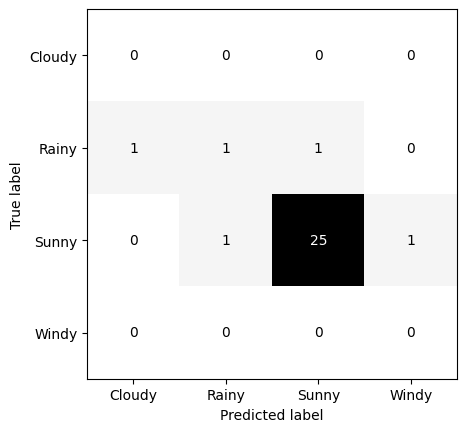

# Implement : DBN + Bi - RNN

In [174]:
DLPipeline = Pipeline([
    ("MinMaxScaler", MinMaxScaler()),
    # ("DBN", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 10, verbose = 0)),
    # ("MinMaxScalerOut", MinMaxScaler()),
])

# DL_X_train = DLPipeline.fit_transform(X_train)
# DL_X_valid = DLPipeline.transform(X_valid)
# DL_X_test = DLPipeline.transform(X_test)

DL_X_train = X_train
DL_X_valid = X_valid
DL_X_test = X_test

DL_Y_train = to_categorical(y_train)
DL_Y_valid = to_categorical(y_valid)
DL_Y_test = to_categorical(y_test)

DLPredictor = Sequential([
    layers.InputLayer((DL_X_train.shape[1], 1)),
    layers.Bidirectional(layers.SimpleRNN(64, return_sequences = True)),
    layers.Bidirectional(layers.SimpleRNN(64, return_sequences = True)),
    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.Flatten(),
    layers.Dense(DL_Y_train.shape[1], activation = "softmax")
])

DLPredictor.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

mcp_save = ModelCheckpoint(f"NO_DBN_BI_RNN_50.keras", save_best_only = True, monitor = "accuracy", mode = "max")

history = DLPredictor.fit(
    DL_X_train, DL_Y_train, 
    batch_size = 64, 
    epochs = 25, 
    validation_split = 0.1, 
    validation_data = (DL_X_valid, DL_Y_valid), 
    callbacks = [mcp_save])

Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.5411 - loss: 0.9735 - val_accuracy: 0.6593 - val_loss: 0.7680
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6597 - loss: 0.7537 - val_accuracy: 0.6611 - val_loss: 0.7556
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6664 - loss: 0.7458 - val_accuracy: 0.6657 - val_loss: 0.7363
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6613 - loss: 0.7490 - val_accuracy: 0.6713 - val_loss: 0.7494
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6652 - loss: 0.7413 - val_accuracy: 0.6602 - val_loss: 0.7463
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6670 - loss: 0.7265 - val_accuracy: 0.6538 - val_loss: 0.7547
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6721 - loss: 0.7244 - val_accuracy: 0.6621 - val_loss: 0.7287
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6712 - loss: 0.7216 - val_accuracy: 0.6648 - 

In [175]:
DLPredictor = load_model("NO_DBN_BI_RNN_50.keras")

In [176]:
history = history.history 

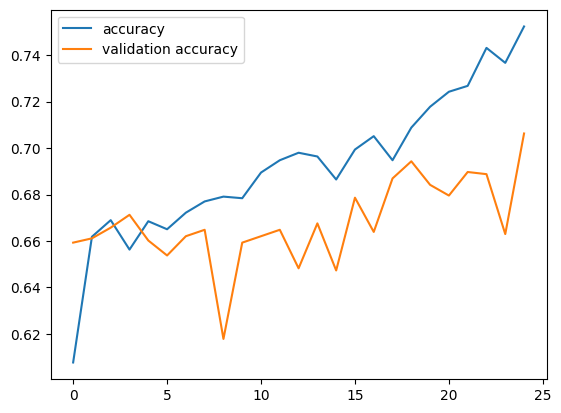

In [177]:
plt.figure()
plt.plot(history["accuracy"], label = "accuracy")
plt.plot(history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()

In [178]:
DL_Y_predict = DLPredictor.predict(DL_X_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [179]:
accuracy_score(
    np.argmax(DL_Y_test, axis = 1), 
    np.argmax(DL_Y_predict, axis = 1))

0.7128129602356407

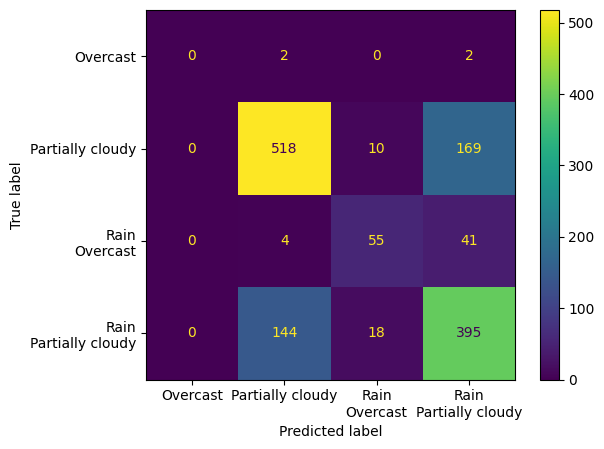

In [180]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        np.argmax(DL_Y_test, axis = 1), 
        np.argmax(DL_Y_predict, axis = 1)), 
    display_labels = LE.classes_).plot()

In [182]:
dl_y_pred = np.argmax(DLPredictor.predict(X_deploy), axis = 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [184]:
accuracy_score(y_deploy, dl_y_pred)

0.23076923076923078

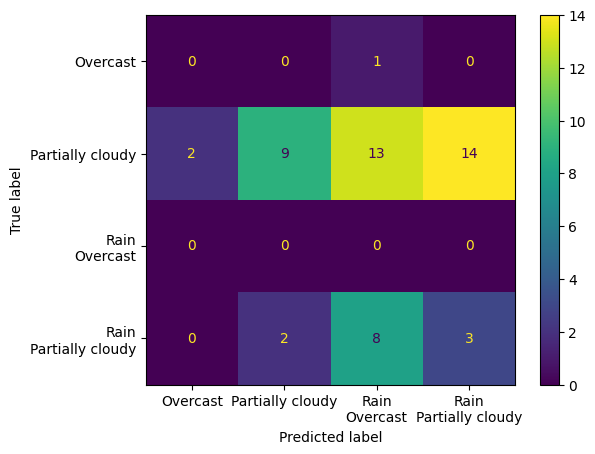

In [183]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_deploy, dl_y_pred), 
    display_labels = LE.classes_).plot()